In [2]:
import pandas as pd
import numpy as np
import datetime
import math
import os
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy.optimize import curve_fit

plt.style.use('ggplot')
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [3]:
#インプットパワーカーブ
input_power_curve = pd.read_csv('Wind_turbine/Ampiar_power_curve.csv')
input_power_curve

,Wind speed(m/s),Power(kW)
0,1,0.000
1,2,0.000
2,3,0.004
3,4,0.010
4,5,0.020
5,6,0.034
6,7,0.051
7,8,0.076
8,9,0.110
9,10,0.144


In [4]:
def func(x, a, b, c):
    return a*x**2+b*x+c

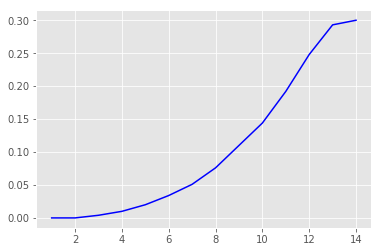

In [5]:
plt.plot(input_power_curve['Wind speed(m/s)'], input_power_curve['Power(kW)'], 'b-', label='data')

array([ 0.00220261, -0.00783915,  0.00496154])

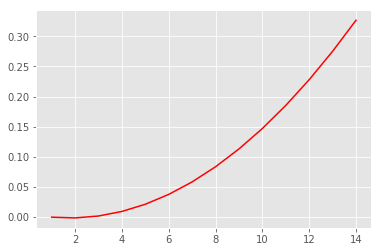

In [6]:
popt, pcov = curve_fit(func, input_power_curve['Wind speed(m/s)'].values, input_power_curve['Power(kW)'].values)

plt.plot(input_power_curve['Wind speed(m/s)'].values, func(input_power_curve['Wind speed(m/s)'].values, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
popt

In [6]:
def power_curve_func(x,rated_output,cutin,popt):
    if x > 14:
        output = 0.3
    else:
        if x < cutin:
             output= 0
        else:
            output= popt[0]*x**2+popt[1]*x+popt[2]
    return output/rated_output

def wind_turbine_output(wind_values,temp_values,MSL_values,Pr,V_rat, V_CIN, V_CO):   
    # Pr:rated power, V_rat: rated wind speed,V_CIN: cut-in speed, V=CO: cut-out speed,rho: air dencity
    rho0 = 1.225
    rho = MSL_values / (2.87*273.15+2.87*temp_values)
    Pwt=(np.where((V_rat<=wind_values) & (wind_values <= V_CO), Pr,\
                  np.where((V_CIN<=wind_values) & (wind_values <= V_rat), \
                           Pr*(wind_values-V_CIN)/(V_rat-V_CIN),0 )))
    return (Pwt*(rho/rho0))/Pr

In [7]:
input_data_sheet = pd.read_csv('Wind_turbine/Ampiar_data_sheet.csv')
input_data_sheet

,Rated power,Rated wind speed,Cut-in wind speed,Cut-out wind speed,Maximum wind speed the turbine can withstand
0,0.3,12.6,3,None,180


In [8]:
input_data = pd.read_csv('Wind_turbine/Wind_speed.csv')

input_data['Date'] = input_data[['Year', 'Month', 'Day','Hour']].apply(lambda x: '{}@{}@{}@{}'.format(x[0], x[1], x[2],x[3]), axis=1)
Time = input_data['Date']
input_data['Date'] =pd.to_datetime(Time, format='%Y@%m@%d@%H')

input_data.head()

,Time,Year,Month,Day,Hour,Minute,Realtime wind speed,Forecast wind speed,Date
0,2019/6/17 0:00,2019,6,17,0,0,1.5,1.539670,2019-06-17 00:00:00
1,2019/6/17 1:00,2019,6,17,1,0,1.0,1.602270,2019-06-17 01:00:00
2,2019/6/17 2:00,2019,6,17,2,0,0.9,1.425374,2019-06-17 02:00:00
3,2019/6/17 3:00,2019,6,17,3,0,1.1,1.105372,2019-06-17 03:00:00
4,2019/6/17 4:00,2019,6,17,4,0,0.8,0.353996,2019-06-17 04:00:00


In [9]:
input_data['Realtime wind output[kWh]'] = input_data['Realtime wind speed'].apply(
    power_curve_func, rated_output=input_data_sheet['Rated power'],cutin=input_data_sheet['Cut-in wind speed'][0])

input_data['Forecast wind output[kWh]'] = input_data['Forecast wind speed'].apply(
    power_curve_func, rated_output=input_data_sheet['Rated power'],cutin=input_data_sheet['Cut-in wind speed'][0])

input_data

,Time,Year,Month,Day,Hour,Minute,Realtime wind speed,Forecast wind speed,Date,Realtime wind output[kWh],Forecast wind output[kWh]
0,2019/6/17 0:00,2019,6,17,0,0,1.5,1.539670,2019-06-17 00:00:00,0.000000,0.000000
1,2019/6/17 1:00,2019,6,17,1,0,1.0,1.602270,2019-06-17 01:00:00,0.000000,0.000000
2,2019/6/17 2:00,2019,6,17,2,0,0.9,1.425374,2019-06-17 02:00:00,0.000000,0.000000
3,2019/6/17 3:00,2019,6,17,3,0,1.1,1.105372,2019-06-17 03:00:00,0.000000,0.000000
4,2019/6/17 4:00,2019,6,17,4,0,0.8,0.353996,2019-06-17 04:00:00,0.000000,0.000000
5,2019/6/17 5:00,2019,6,17,5,0,1.4,0.868531,2019-06-17 05:00:00,0.000000,0.000000
6,2019/6/17 6:00,2019,6,17,6,0,2.2,1.282910,2019-06-17 06:00:00,0.000000,0.000000
7,2019/6/17 7:00,2019,6,17,7,0,0.8,1.713929,2019-06-17 07:00:00,0.000000,0.000000
8,2019/6/17 8:00,2019,6,17,8,0,1.1,1.304500,2019-06-17 08:00:00,0.000000,0.000000
9,2019/6/17 9:00,2019,6,17,9,0,1.5,0.793919,2019-06-17 09:00:00,0.000000,0.000000


In [10]:
input_data.to_csv('Wind_turbine/Wind_result.csv',encoding="shift_jis")   